# Parametric shape optimization with differentiable FEM simulation

## Introduction

In this notebook, we explore the optimization of a parametric structure made of a linear elastic material.

We denote the design space as a function $g$ that maps the design variables to a signed distance field. Then, we can then define the density field $\rho(\mathbf{x})$ as a function of a signed distance field (SDF) value $g(\mathbf{x})$. For adaptive meshing, we define a sizing field $h(\mathbf{x})$ as a function of the SDF value as well.
We introduce an adpative differentiable mesher $m$ that takes the sizing field and returns a hex mesh. Finally we denote the differentiable finite element method (FEM) solver as $f$, which takes the density field and the hex mesh as input and returns the structure's compliance.  Therefore, the optimization problem can be formulated as follows:

$$
\begin{equation}
\min_{\theta} f(m(g(\theta)), \rho(g(\theta))).
\end{equation}
$$

Here, $\theta$ is the vector of design variables.

## Setup

In [222]:
# Install additional requirements for this notebook
# %pip install -r requirements.txt -q --isolated

In [223]:
# import tesseract_core

# tesseract_core.build_tesseract("design_tess", "latest")
# tesseract_core.build_tesseract("fem_tess", "latest")
# tesseract_core.build_tesseract("meshing_tess", "latest")
# print("Tesseract built successfully.")

## Design Space Tesseract

In [352]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tesseract_core import Tesseract
from tesseract_core.runtime.experimental import TesseractReference

from tesseract_jax import apply_tesseract

In [353]:
# design_tess = Tesseract.from_image("design-tube-sdf")
# design_tess.serve()
design_tess = Tesseract.from_tesseract_api("sdf_fd_tess/tesseract_api.py")
bar_3d_tess = Tesseract.from_tesseract_api("bars_3d_tess/tesseract_api.py")

Now we can setup the parameters for the design space and apply the design Tesseract. The Tesseract constructs a 3D geometry using PyVista and computes its signed distance field (SDF).

In [354]:
n_chains = 2
n_edges_per_chain = 3
bar_radius = 1.2

Lx, Ly, Lz = 20.0, 10.0, 10.0
Nx, Ny, Nz = 128, 64, 64

# Initialize chain parameter array
initial_params = jnp.zeros((n_chains, n_edges_per_chain + 1, 3), dtype=jnp.float32)

for chain in range(n_chains):
    initial_params = initial_params.at[chain, :, 0].set(
        jnp.linspace(-Lx / 2, Lx / 2, n_edges_per_chain + 1)
    )

    initial_params = initial_params.at[chain, :, 2].set(
        (chain + 1) / (n_chains + 1) * Ly - Ly / 2
    )

initial_params = initial_params.at[0, 0, 2].set(-5)

initial_params = initial_params.flatten()

normalization_factors = jnp.ones_like(initial_params, dtype=jnp.float32) * 0.1
initial_params = initial_params * normalization_factors
normalization_bias = jnp.zeros_like(initial_params, dtype=jnp.float32)


design_inputs = {
    "non_differentiable_parameters": jnp.array([bar_radius], dtype=jnp.float32),
    "static_parameters": [n_chains, n_edges_per_chain + 1],
    "string_parameters": [],
    "mesh_tesseract": TesseractReference(bar_3d_tess),
    "grid_size": [Lx, Ly, Lz],
    "grid_elements": [Nx, Ny, Nz],
    "epsilon": 0.001,  # epsilon, only used for FD of the jacobian
    "grid_center": [0.0, 0.0, 0.0],
    "max_points": 2000,
    "max_faces": 4000,
    "normalization_factors": normalization_factors,
    "normalization_bias": normalization_bias,
    "normalize_jacobian": False,
    "precompute_jacobian": False,
    "sdf_backend": "pyvista",
}

design_out = design_tess.apply(
    {
        "differentiable_parameters": initial_params,
        **design_inputs,
    }
)
sdf = design_out["sdf"]
surface_mesh = design_out["mesh"]

num_vertices = surface_mesh["n_points"]
num_faces = surface_mesh["n_faces"]

print(f"Number of vertices: {num_vertices}")
print(f"Number of faces: {num_faces}")

points = surface_mesh["points"][:num_vertices]
faces = surface_mesh["faces"][:num_faces]

mesh = {
    "points": points,
    "faces": faces,
}

print("SDF shape:", sdf.shape)

Number of vertices: 240
Number of faces: 472
SDF shape: (128, 64, 64)


To better understand what's going on, let's import some internal functions from the design Tesseract, and visualize the structure and its SDF field.

TODOs>
- fix bcs
- plot parts of jacobian for parameters
- scaling VN bcs instead of gradients in FD


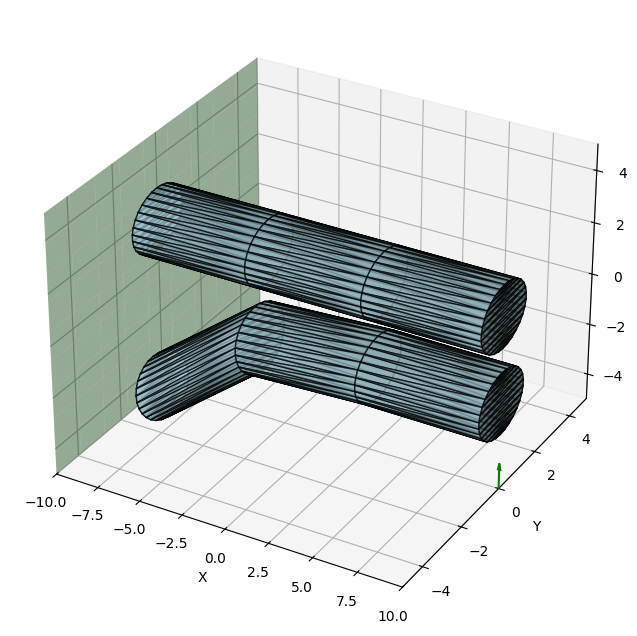

In [355]:
def plot_mesh(mesh: dict, save_path: str | None = None) -> None:
    """Plot a 3D triangular mesh with boundary conditions visualization.

    Args:
        mesh: Dictionary containing 'points' and 'faces' arrays.
        save_path: Optional path to save the plot as an image file.
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_trisurf(
        mesh["points"][:, 0],
        mesh["points"][:, 1],
        mesh["points"][:, 2],
        triangles=mesh["faces"],
        alpha=0.7,
        antialiased=True,
        color="lightblue",
        edgecolor="black",
    )

    # plane on x=0 to visualize dirichlet boundary
    yy, zz = jnp.meshgrid(
        jnp.linspace(-Ly / 2, Ly / 2, 10), jnp.linspace(-Ly / 2, Ly / 2, 10)
    )
    xx = -jnp.ones_like(yy) * Lx / 2
    ax.plot_surface(xx, yy, zz, alpha=0.4, color="green")

    ax.set_xlim(-Lx / 2, Lx / 2)
    ax.set_ylim(-Ly / 2, Ly / 2)
    ax.set_zlim(-Lz / 2, Lz / 2)

    # x axis label
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

    # green arrow on bottom right to indicate force direction
    ax.quiver(
        Lx / 2,
        0,
        -Lz / 2,
        0,
        0,
        1,
        length=1.0,
        color="green",
        arrow_length_ratio=0.3,
    )

    if save_path:
        # avoid showing the plot in notebook
        plt.savefig(save_path)
        plt.close(fig)


plot_mesh(mesh)

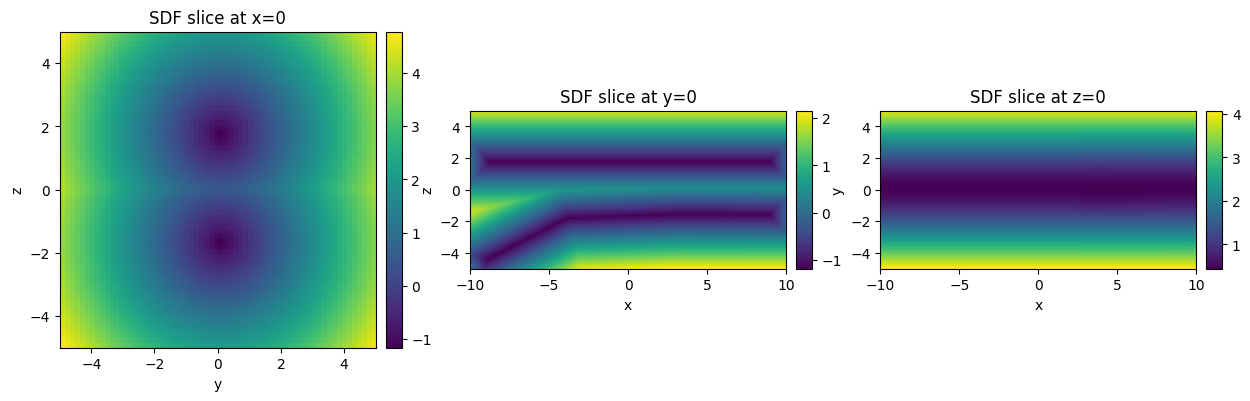

In [356]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_grid_slice(field_slice, extent, ax, title, xlabel, ylabel, log_scale=False):
    im = ax.imshow(field_slice.T, extent=extent, origin="lower")
    # norm=colors.CenteredNorm())
    # norm=colors.LogNorm(vmin=field_slice.min().item(), vmax=field_slice.max().item()) if log_scale else None)

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    # add colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax, orientation="vertical")
    return im


def plot_grid(field, Lx, Ly, Lz, Nx, Ny, Nz):
    _, axs = plt.subplots(1, 3, figsize=(15, 5))

    plot_grid_slice(
        field[Nx // 2, :, :],
        extent=(-Ly / 2, Ly / 2, -Lz / 2, Lz / 2),
        ax=axs[0],
        title="SDF slice at x=0",
        xlabel="y",
        ylabel="z",
    )
    plot_grid_slice(
        field[:, Ny // 2, :],
        extent=(-Lx / 2, Lx / 2, -Lz / 2, Lz / 2),
        ax=axs[1],
        title="SDF slice at y=0",
        xlabel="x",
        ylabel="z",
    )
    plot_grid_slice(
        field[:, :, Nz // 2],
        extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
        ax=axs[2],
        title="SDF slice at z=0",
        xlabel="x",
        ylabel="y",
    )


plot_grid(sdf, Lx, Ly, Lz, Nx, Ny, Nz)

And figure out an approate epsilon for finite difference based Jacobian computation.

In [229]:
# # Lets figure out a good epsilon value for FD jacobian computation
# epsilons = jnp.logspace(-6, -1, 5)
# mean_grads = []
# std_grads = []

# for i in range(len(epsilons)):
#     eps = epsilons[i]

#     design_inputs_eps = design_inputs.copy()
#     design_inputs_eps["epsilon"] = eps.item()

#     primal, vjp_fun = jax.vjp(
#         lambda params,  design_params=design_inputs_eps: apply_tesseract(
#             design_tess,
#             {
#                 "differentiable_parameters": params.flatten(),
#                 **design_params,
#             },
#         )["sdf"],
#         initial_params,
#     )

#     grad = vjp_fun(jnp.ones((Nx, Ny, Nz), dtype=jnp.float32))[0]

#     mean_grads.append(jnp.mean(jnp.abs(grad)))
#     std_grads.append(jnp.std(grad))

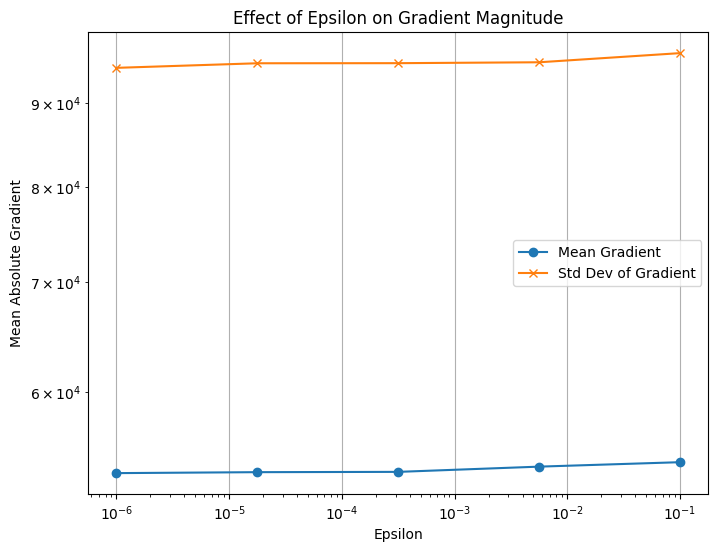

In [ ]:
# plt.figure(figsize=(8, 6))
# plt.plot(epsilons, mean_grads, marker="o")
# plt.plot(epsilons, std_grads, marker="x")
# plt.xlabel("Epsilon")
# plt.xscale("log")
# plt.yscale("log")
# plt.ylabel("Mean Absolute Gradient")
# plt.title("Effect of Epsilon on Gradient Magnitude")
# plt.grid(True)
# plt.legend(["Mean Gradient", "Std Dev of Gradient"])

In [324]:
result = design_tess.jacobian(
    inputs={
        "differentiable_parameters": initial_params,
        **design_inputs,
    },
    jac_inputs=["differentiable_parameters"],
    jac_outputs=["sdf"],
)

Computing Jacobian...


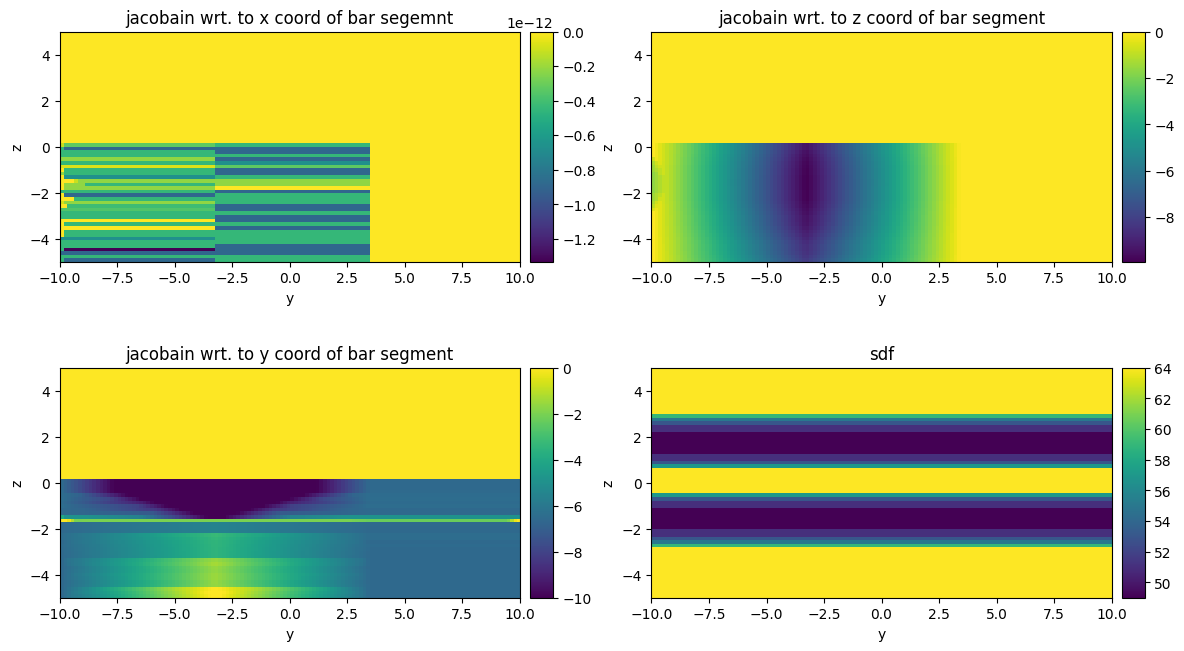

In [325]:
fig, axs = plt.subplots(2, 2, figsize=(14, 8))

plot_grid_slice(
    jnp.min(jnp.clip(result["sdf"]["differentiable_parameters"][3], -10, 0), 2),
    extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
    ax=axs[0, 0],
    title="jacobain wrt. to x coord of bar segemnt",
    xlabel="y",
    ylabel="z",
    log_scale=True,
)

plot_grid_slice(
    jnp.min(jnp.clip(result["sdf"]["differentiable_parameters"][4], -10, 0), 2),
    extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
    ax=axs[1, 0],
    title="jacobain wrt. to y coord of bar segment",
    xlabel="y",
    ylabel="z",
    log_scale=True,
)

plot_grid_slice(
    jnp.min(jnp.clip(result["sdf"]["differentiable_parameters"][5], -10, 0), 2),
    extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
    ax=axs[0, 1],
    title="jacobain wrt. to z coord of bar segment",
    xlabel="y",
    ylabel="z",
    log_scale=True,
)

plot_grid_slice(
    jnp.sum(sdf > 0, 2),
    extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
    ax=axs[1, 1],
    title="sdf",
    xlabel="y",
    ylabel="z",
    log_scale=True,
)

## Density and Sizing Field

rho min: 7.329537038458511e-05, rho max: 0.9154974818229675


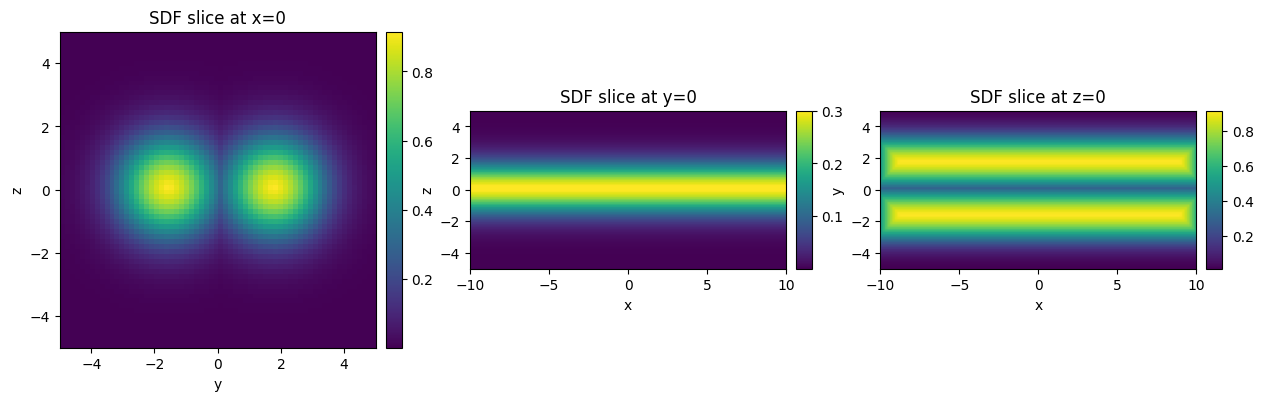

In [326]:
def sdf_to_rho(
    sdf: jnp.ndarray, scale: float = 2.0, offset: float = 0.1
) -> jnp.ndarray:
    """Convert signed distance function to material density using sigmoid.

    Args:
        sdf: Signed distance function values.
        scale: Sigmoid steepness (higher = sharper transition).
        offset: SDF value where density = 0.5.

    Returns:
        Material density field in [0,1].
    """
    return 1 / (1 + jnp.exp(scale * sdf - offset))


rho = sdf_to_rho(sdf, scale=2)

plot_grid(rho, Lx, Ly, Lz, Nx, Ny, Nz)
print(f"rho min: {jnp.min(rho)}, rho max: {jnp.max(rho)}")

Sizing field min: 0.625, max: 2.5


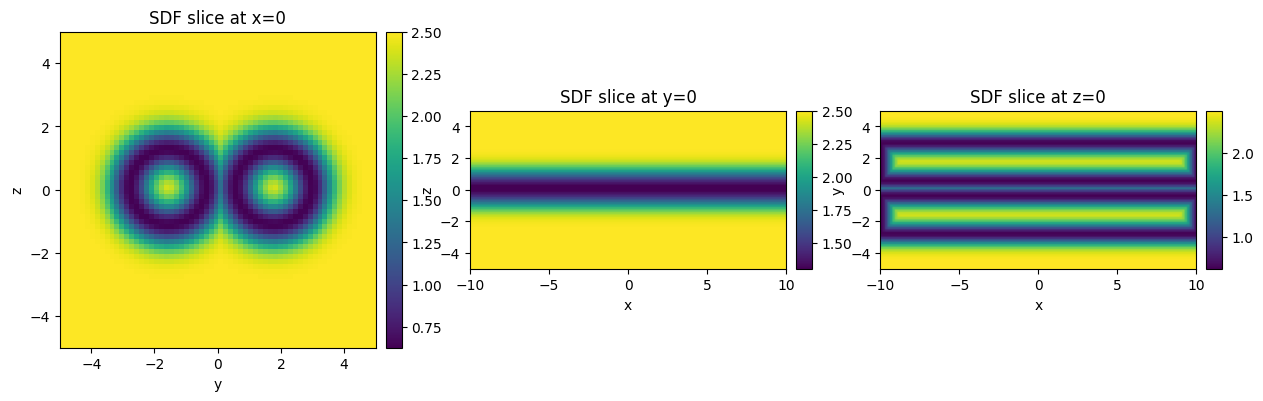

In [327]:
def sizing_field(
    sdf: jnp.ndarray, min_size: float = 0.1, max_size: float = 1.0, scale: float = 2.0
) -> jnp.ndarray:
    """Generate a sizing field from the signed distance function.

    The field is low (size = min_size) near the structure (sdf=0) and high (size = max_size) far from it.

    Args:
        sdf: Signed distance function values.
        min_size: Minimum element size near the structure.
        max_size: Maximum element size far from the structure.
        scale: Controls the transition steepness.

    Returns:
        Sizing field values.
    """

    def gauss(x: jnp.ndarray, mu: float, sigma: float) -> jnp.ndarray:
        return jnp.exp(-0.5 * ((x - mu) / sigma) ** 2)

    normalized_sdf = 1 - gauss(sdf, 0.0, 1.0 / scale)
    return min_size + (max_size - min_size) * normalized_sdf


sizing_min = Lx / 32
sizing_max = Lx / 8
sizing_scale = 2.0
sizing = sizing_field(sdf, min_size=sizing_min, max_size=sizing_max, scale=sizing_scale)
plot_grid(sizing, Lx, Ly, Lz, Nx, Ny, Nz)
print(f"Sizing field min: {sizing.min()}, max: {sizing.max()}")

## Adpative Hex Meshing Tesseract

In [328]:
mesher = Tesseract.from_tesseract_api("meshing_tess/tesseract_api.py")

max_points = 30000
max_cells = 30000

mesher_out = apply_tesseract(
    mesher,
    {
        "domain_size": [Lx, Ly, Lz],
        "sizing_field": sizing,
        "field_values": rho,
        "max_subdivision_levels": 3,
        "max_points": max_points,
        "max_cells": max_cells,
    },
)
print(
    f"Mesh points: {mesher_out['mesh']['n_points']}, Mesh faces: {mesher_out['mesh']['n_faces']}"
)
pts = mesher_out["mesh"]["points"][: mesher_out["mesh"]["n_points"]]
hex_cells = mesher_out["mesh"]["faces"][: mesher_out["mesh"]["n_faces"]]

adaptive_mesh = mesher_out["mesh"]

print(jnp.max(mesher_out["mesh_cell_values"]))
print(mesher_out["mesh_cell_values"].shape)

Done building mesh
Mesh points: 10615, Mesh faces: 8736
0.8963216
(30000,)


Lets check the gradient of the meshing Tesseract

In [281]:
# primal, vjp_fun = jax.vjp(
#     lambda rho: apply_tesseract(
#         mesher,
#         {
#             "domain_size": [Lx, Ly, Lz],
#             "sizing_field": sizing,
#             "field_values": rho,
#             "max_subdivision_levels": 3,
#             "max_points": max_points,
#             "max_cells": max_cells,
#         },
#     )["mesh_cell_values"],
#     rho,
# )

# grad = vjp_fun(jax.numpy.ones((max_cells), dtype=jax.numpy.float32) * 0.5)[0]

# print("Gradient shape:", grad.shape)
# print(f"Max grad: {jnp.max(grad)}, Min grad: {jnp.min(grad)}")

Lets examine the produced mesh by exporting it to a VTK file and visualizing it in Paraview.

In [330]:
# Lets export it to a .vtk using pyvista
import numpy as np
import pyvista as pv


def hex_to_pyvista(
    pts: jax.typing.ArrayLike, faces: jax.typing.ArrayLike, cell_data: dict
) -> pv.UnstructuredGrid:
    """Convert hex mesh defined by points and faces into a PyVista UnstructuredGrid.

    Args:
        pts: Array of point coordinates, shape (N, 3).
        faces: Array of hexahedral cell connectivity, shape (M, 8).
        cell_data: additional cell center data.

    Returns:
        PyVista mesh representing the hexahedral grid.
    """
    pts = np.array(pts)
    faces = np.array(faces)

    # Define the cell type for hexahedrons (VTK_HEXAHEDRON = 12)
    cell_type = pv.CellType.HEXAHEDRON
    cell_types = np.array([cell_type] * faces.shape[0], dtype=np.uint8)

    # Prepare the cells array: [number_of_points, i0, i1, i2, i3, i4, i5, i6, i7]
    n_cells = faces.shape[0]
    cells = np.empty((n_cells, 9), dtype=np.int64)
    cells[:, 0] = 8  # Each cell has 8 points
    cells[:, 1:9] = faces

    # Flatten the cells array for PyVista
    cells = cells.flatten()

    mesh = pv.UnstructuredGrid(cells, cell_types, pts)

    # Add cell data
    for name, data in cell_data.items():
        mesh.cell_data[name] = data

    return mesh


# convert arrays to numpy
pts_np = np.array(adaptive_mesh["points"][: adaptive_mesh["n_points"]])
cells_np = np.array(adaptive_mesh["faces"][: adaptive_mesh["n_faces"]])

hex_mesh = hex_to_pyvista(
    pts_np,
    cells_np,
    {"rho": mesher_out["mesh_cell_values"][: adaptive_mesh["n_faces"]]},
)

print(hex_mesh)

hex_mesh.save("bars_mesh.vtk")

UnstructuredGrid (0x77b2c39e7ee0)
  N Cells:    8736
  N Points:   10615
  X Bounds:   -1.000e+01, 1.000e+01
  Y Bounds:   -5.000e+00, 5.000e+00
  Z Bounds:   -5.000e+00, 5.000e+00
  N Arrays:   1


## Boundary Conditions

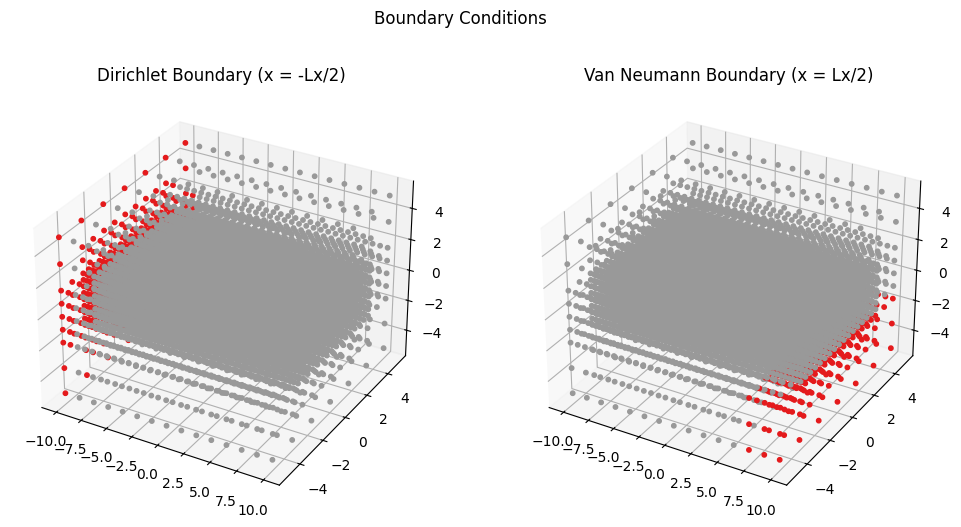

In [ ]:
# Lets setup the boundary conditions


def get_boundary_masks(mesh: dict, Lx: float, Lz: float):
    """Get boundary condition masks for the adaptive mesh.

    Args:
        mesh: Dictionary containing 'points' array.
        Lx: Size of the domain in x-direction.
        Lz: Size of the domain in z-direction.

    Returns:
        dirichlet_mask: Boolean array for Dirichlet boundary condition.
        van_neumann_mask: Boolean array for Van Neumann boundary condition.
    """
    pts = mesh["points"]

    dirichlet_mask = pts[:, 0] <= -Lx / 2 + Lx / 20
    van_neumann_mask = jnp.logical_and(
        jnp.isclose(pts[:, 0], Lx / 2, atol=Lz / 3),
        jnp.isclose(pts[:, 2], -Lz / 2, atol=Lz / 3),
    )

    return dirichlet_mask, van_neumann_mask


dirichlet_mask, van_neumann_mask = get_boundary_masks(adaptive_mesh, Lx, Lz)

fig, axs = plt.subplots(1, 2, subplot_kw={"projection": "3d"}, figsize=(12, 6))
# set the colormap to Set1
plt.suptitle("Boundary Conditions")
# remove the axis ticks
pts = adaptive_mesh["points"][: adaptive_mesh["n_points"]]

axs[0].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=jnp.where(dirichlet_mask[: adaptive_mesh["n_points"]], 0.1, 0.2),
    s=10,
    alpha=1.0,
    cmap="Set1",
)
axs[0].set_title("Dirichlet Boundary (x = -Lx/2)")

axs[1].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=jnp.where(van_neumann_mask[: adaptive_mesh["n_points"]], 0.1, 0.2),
    s=10,
    alpha=1.0,
    cmap="Set1",
)
axs[1].set_title("Van Neumann Boundary (x = Lx/2)")

# convert to int arrays for tesseract input
dirichlet_mask = dirichlet_mask.astype(jnp.int32)
van_neumann_mask = van_neumann_mask.astype(jnp.int32)

In [262]:
# fem_tess = Tesseract.from_image("structure-jax-fem")
# fem_tess.serve()

fem_tess = Tesseract.from_tesseract_api("fem_tess/tesseract_api.py")

In [284]:
# compliance = apply_tesseract(
#     fem_tess,
#     {
#         "rho": jnp.expand_dims(mesher_out["mesh_cell_values"], axis=-1),
#         "hex_mesh": adaptive_mesh,
#         "dirichlet_mask": dirichlet_mask,
#         "dirichlet_values": jnp.array([0.0]),
#         "van_neumann_mask": van_neumann_mask,
#         "van_neumann_values": jnp.array([[0.0, 0.0, 1.0]]),
#     },
# )["compliance"]
# print(f"Compliance: {compliance:.4f}")

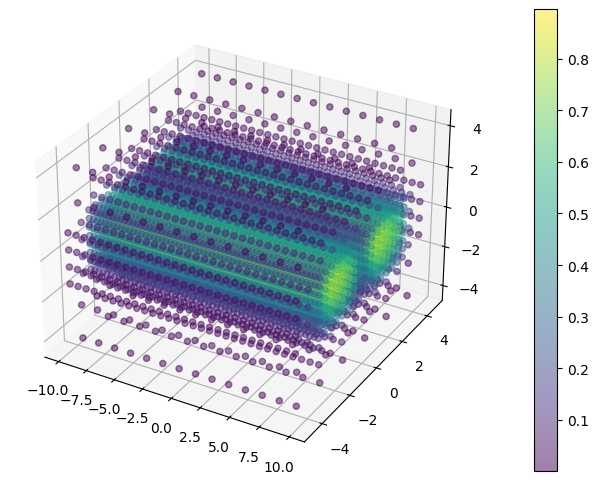

In [332]:
# lets make a scatter plot of the mesh cell values as colors
fig, ax = plt.subplots(1, 1, figsize=(8, 6), subplot_kw={"projection": "3d"})
pts_coords = mesher_out["mesh"]["points"][: mesher_out["mesh"]["n_points"]]
hex_cells = mesher_out["mesh"]["faces"][: mesher_out["mesh"]["n_faces"]]
center_points = jnp.mean(pts_coords[hex_cells], axis=1)
rho_mesh = mesher_out["mesh_cell_values"][: mesher_out["mesh"]["n_faces"]]
scat = ax.scatter(
    center_points[:, 0],
    center_points[:, 1],
    center_points[:, 2],
    c=rho_mesh,
    s=20,
    # alpha=rho+0.3,
    alpha=0.5,
    cmap="viridis",
)
# colorbar
cbar = plt.colorbar(scat, ax=ax, pad=0.1)

In [333]:
from typing import TypeVar

T = TypeVar("T")


def stop_grads_int(x: T) -> T:
    """Stops gradient computation.

    We cannot use jax.lax.stop_gradient directly because Tesseract meshes are
    nested dictionaries with arrays and integers, and jax.lax.stop_gradient
    does not support integers.

    Args:
        x: Input value.

    Returns:
        Value with stopped gradients.
    """

    def stop(x):
        return jax._src.ad_util.stop_gradient_p.bind(x)

    return jax.tree_util.tree_map(stop, x)

In [334]:
from jax import custom_vjp

grad_storage = {}


def store_values(x, x_dot, hash_val: int):
    global grad_storage
    print("Storing values in hash", hash_val)
    grad_storage[int(hash_val)] = (x, x_dot)


@custom_vjp
def identity_and_store_grads(x, hash_val: int):
    return x


def identity_fwd(x, hash_val):
    return x, (x, hash_val)


def identity_bwd(residuals, g):
    x, hash_val = residuals
    jax.debug.callback(store_values, x, g, hash_val, ordered=False)
    return (g, None)


identity_and_store_grads.defvjp(identity_fwd, identity_bwd)

In [335]:
max_points = 15000
max_cells = 15000


def loss(
    params: jnp.ndarray,
    iteration: int = 0,
) -> tuple[float, dict]:
    """Compute structural compliance for given bar parameters.

    Args:
        params: Bar parameter array with shape (n_chains, n_nodes, 3).
        iteration: current optim iteration.

    Returns:
        Structural compliance (scalar). Lower values indicate better performance.
    """
    # Generate signed distance field from design parameters
    # params = identity_and_store_grads(params, iteration + 0)
    design_out = apply_tesseract(
        design_tess,
        {"differentiable_parameters": params.flatten(), **design_inputs},
    )

    sdf = design_out["sdf"]

    sdf = identity_and_store_grads(sdf, iteration + 1000)

    # Convert SDF to material density distribution
    rho_grid = sdf_to_rho(sdf, scale=2)

    rho_grid = identity_and_store_grads(rho_grid, iteration + 2000)

    sizing = sizing_field(
        sdf, min_size=sizing_min, max_size=sizing_max, scale=sizing_scale
    )
    sizing = jax.lax.stop_gradient(sizing)

    mesher_out = apply_tesseract(
        mesher,
        {
            "domain_size": [Lx, Ly, Lz],
            "sizing_field": sizing,  # jnp.ones_like(sdf) * (Lx / 10),
            "field_values": rho_grid,
            "max_subdivision_levels": 2,
            "max_points": max_points,
            "max_cells": max_cells,
        },
    )

    rho_cell = jnp.expand_dims(mesher_out["mesh_cell_values"], axis=-1)
    rho_cell = identity_and_store_grads(rho_cell, iteration + 3000)

    mesh = stop_grads_int(mesher_out["mesh"])

    dirichlet_mask, van_neumann_mask = get_boundary_masks(mesh, Lx, Lz)

    van_neumann_mask = jax.lax.stop_gradient(van_neumann_mask)
    dirichlet_mask = jax.lax.stop_gradient(dirichlet_mask)
    dirichlet_values = jnp.array([0.0])
    van_neumann_values = jnp.array([[0.0, 0.0, 0.1]])

    # Instead of passing all inputs and trying to stop_gradient on them,
    # we need to wrap the tesseract call to only allow gradients w.r.t. rho
    c = apply_tesseract(
        fem_tess,
        {
            "rho": rho_cell,
            "hex_mesh": mesh,
            "dirichlet_mask": dirichlet_mask,
            "dirichlet_values": dirichlet_values,
            "van_neumann_mask": van_neumann_mask,
            "van_neumann_values": van_neumann_values,
        },
    )["compliance"]

    surface_mesh = {
        "points": design_out["mesh"]["points"][: design_out["mesh"]["n_points"]],
        "faces": design_out["mesh"]["faces"][: design_out["mesh"]["n_faces"]],
    }

    hex_mesh = {
        "points": mesher_out["mesh"]["points"][: mesher_out["mesh"]["n_points"]],
        "faces": mesher_out["mesh"]["faces"][: mesher_out["mesh"]["n_faces"]],
        "rho": mesher_out["mesh_cell_values"][: mesher_out["mesh"]["n_faces"]],
    }

    return c, {
        "sdf": sdf,
        "rho_grid": rho_grid,
        "sizing": sizing,
        "hex_mesh": hex_mesh,
        "surface_mesh": surface_mesh,
    }

In [336]:
grad_fn = jax.value_and_grad(loss, has_aux=True)

## Lets have a look at the gradients

In [337]:
(loss_value, aux), grads = grad_fn(initial_params, iteration=0)
print(f"loss {loss_value}, grads {grads}")

Done building mesh


[11-21 15:28:37][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-21 15:28:37][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-21 15:28:37][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-21 15:28:39][DEBUG] jax_fem: Done pre-computations, took 1.1220717430114746 [s]
[11-21 15:28:39][INFO] jax_fem: Solving a problem with 2464 cells, 3199x3 = 9597 dofs.
[11-21 15:28:39][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-21 15:28:40][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-21 15:28:40][DEBUG] jax_fem: Start timing
[11-21 15:28:40][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-21 15:28:41][DEBUG] jax_fem: Function split_and_compute_cell took 0.5252 seconds
[11-21 15:28:42][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-21 15:28:43][DEBUG] jax_fem: Before, l_2 res = 5.001482919423332, relative l_2 res

Storing values in hash 3000
Done building mesh
Storing values in hash 2000
Storing values in hash 1000
Computing Jacobian...
loss 30.739221572875977, grads [ 5.5806231e-01 -2.1873677e+00 -1.8421693e+00  3.3389815e-14
 -1.3982209e+00 -2.2100177e+00  6.7612046e-15 -1.1114326e+00
  6.5901935e-01 -7.0419866e-03 -1.3645653e+00  3.0822701e+00
  4.6622351e-01 -1.1294160e+00 -1.7552319e+00  3.2892797e-14
 -1.3244025e+00 -2.1347806e+00 -2.7186454e-15 -3.4139357e+00
  4.7414169e-01 -6.3064550e-03 -3.5220008e+00  2.6121643e+00]


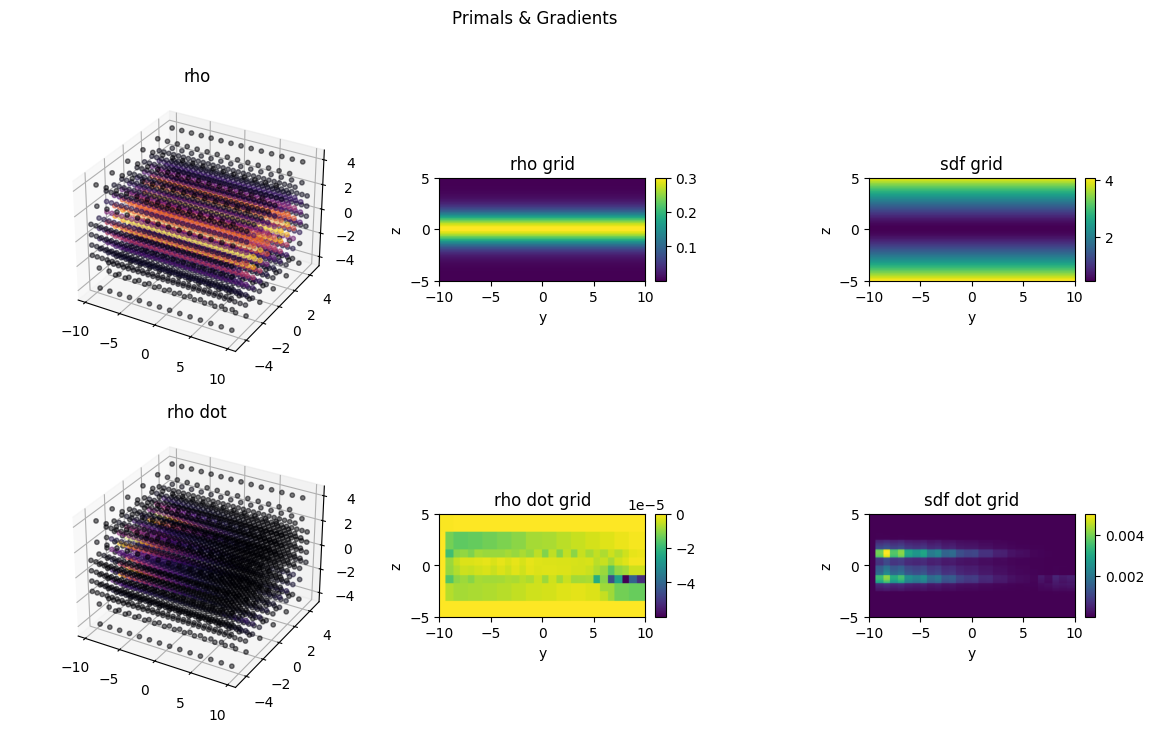

In [338]:
fig, axs = plt.subplots(2, 3, figsize=(14, 8))
plt.suptitle("Primals & Gradients")
axs[0, 0].set_xticks([])
axs[0, 0].set_yticks([])
axs[1, 0].set_xticks([])
axs[1, 0].set_yticks([])

ax = axs[0, 0]
for spine in ax.spines.values():
    spine.set_visible(False)

ax = axs[1, 0]
for spine in ax.spines.values():
    spine.set_visible(False)

# Set the first two subplots to 3D
axs[0, 0] = fig.add_subplot(2, 2, 1, projection="3d")
axs[1, 0] = fig.add_subplot(2, 2, 3, projection="3d")


mesh = aux["hex_mesh"]

pts_coords = mesh["points"]
hex_cells = mesh["faces"]
pts = jnp.mean(pts_coords[hex_cells], axis=1)

axs[0, 0].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=mesh["rho"],
    s=10,
    alpha=0.5,
    cmap="inferno",
)
axs[0, 0].set_title("rho")

axs[1, 0].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=-grad_storage[3000][1][: mesh["rho"].shape[0]],
    s=10,
    alpha=0.5,
    cmap="inferno",
)
axs[1, 0].set_title("rho dot")

plot_grid_slice(
    aux["rho_grid"][:, Ny // 2, :],
    extent=(-Lx / 2, Lx / 2, -Lz / 2, Lz / 2),
    ax=axs[0, 1],
    title="rho grid",
    xlabel="y",
    ylabel="z",
)

plot_grid_slice(
    jnp.max(grad_storage[2000][1], axis=1),
    extent=(-Lx / 2, Lx / 2, -Lz / 2, Lz / 2),
    ax=axs[1, 1],
    title="rho dot grid",
    xlabel="y",
    ylabel="z",
)

plot_grid_slice(
    aux["sdf"][:, Ny // 2, :],
    extent=(-Lx / 2, Lx / 2, -Lz / 2, Lz / 2),
    ax=axs[0, 2],
    title="sdf grid",
    xlabel="y",
    ylabel="z",
)

plot_grid_slice(
    jnp.max(grad_storage[1000][1], axis=1),
    extent=(-Lx / 2, Lx / 2, -Lz / 2, Lz / 2),
    ax=axs[1, 2],
    title="sdf dot grid",
    xlabel="y",
    ylabel="z",
)

fig.subplots_adjust(wspace=0.9)
# fig.tight_layout(w_pad=3.0)

In [339]:
print(grads)

[ 5.5806231e-01 -2.1873677e+00 -1.8421693e+00  3.3389815e-14
 -1.3982209e+00 -2.2100177e+00  6.7612046e-15 -1.1114326e+00
  6.5901935e-01 -7.0419866e-03 -1.3645653e+00  3.0822701e+00
  4.6622351e-01 -1.1294160e+00 -1.7552319e+00  3.2892797e-14
 -1.3244025e+00 -2.1347806e+00 -2.7186454e-15 -3.4139357e+00
  4.7414169e-01 -6.3064550e-03 -3.5220008e+00  2.6121643e+00]


In [340]:
import optax

n_steps = 10
# strong learning rate decay
schedule = optax.exponential_decay(
    init_value=0.05, transition_steps=n_steps, decay_rate=0.9, staircase=False
)
optmizer = optax.adam(learning_rate=schedule)
opt_state = optmizer.init(initial_params)

params = initial_params.copy()
loss_hist = []
params_hist = []
aux_hist = []


for i in range(n_steps):
    (loss_value, aux), grads = grad_fn(params, iteration=i)
    aux_hist.append(aux)

    print(grads)
    print(params)

    updates, opt_state = optmizer.update(
        grads, opt_state, params, value=loss_value, grad=grads, value_fn=loss
    )
    params = optax.apply_updates(params, updates)

    # # Ensure parameters are within bounds
    params = params.at[::3].set(initial_params.at[::3].get())

    # params = params.at[1::3].set(
    #     jnp.clip(params[1::3], -Ly / 2 + bar_radius, Ly / 2 - bar_radius)
    # )

    # params = params.at[2::3].set(
    #     jnp.clip(params[2::3], -Lz / 2 + bar_radius, Lz / 2 - bar_radius)
    # )

    loss_hist.append(loss_value)
    params_hist.append(params)

    print(f"Iteration {i + 1}, Loss: {loss_value:.4f}")

[11-21 15:29:46][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-21 15:29:46][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-21 15:29:46][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)


Done building mesh


[11-21 15:29:47][DEBUG] jax_fem: Done pre-computations, took 0.43004441261291504 [s]
[11-21 15:29:47][INFO] jax_fem: Solving a problem with 2464 cells, 3199x3 = 9597 dofs.
[11-21 15:29:47][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-21 15:29:47][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-21 15:29:47][DEBUG] jax_fem: Start timing
[11-21 15:29:47][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-21 15:29:47][DEBUG] jax_fem: Function split_and_compute_cell took 0.3656 seconds
[11-21 15:29:47][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-21 15:29:47][DEBUG] jax_fem: Before, l_2 res = 5.001482919423332, relative l_2 res = 1.0
[11-21 15:29:47][DEBUG] jax_fem: Solving linear system...
[11-21 15:29:47][DEBUG] jax_fem: Scipy Solver - Solving linear system with UMFPACK
[11-21 15:29:49][DEBUG] jax_fem: Scipy Solver - Finished solving, linear solve res = 1.3665791799795818e-10
[11-21 15:29:49][DEBUG] 

Storing values in hash 3000
Done building mesh
Storing values in hash 2000
Storing values in hash 1000
Computing Jacobian...
[ 5.5806231e-01 -2.1873677e+00 -1.8421693e+00  3.3389815e-14
 -1.3982209e+00 -2.2100177e+00  6.7612046e-15 -1.1114326e+00
  6.5901935e-01 -7.0419866e-03 -1.3645653e+00  3.0822701e+00
  4.6622351e-01 -1.1294160e+00 -1.7552319e+00  3.2892797e-14
 -1.3244025e+00 -2.1347806e+00 -2.7186454e-15 -3.4139357e+00
  4.7414169e-01 -6.3064550e-03 -3.5220008e+00  2.6121643e+00]
[-1.         -0.16666667  0.         -0.33333334 -0.16666667  0.
  0.33333334 -0.16666667  0.          1.         -0.16666667  0.
 -1.          0.16666667  0.         -0.33333334  0.16666667  0.
  0.33333334  0.16666667  0.          1.          0.16666667  0.        ]
Iteration 1, Loss: 30.7392
Done building mesh


[11-21 15:30:19][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-21 15:30:19][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-21 15:30:19][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-21 15:30:20][DEBUG] jax_fem: Done pre-computations, took 1.1594769954681396 [s]
[11-21 15:30:20][INFO] jax_fem: Solving a problem with 2037 cells, 2693x3 = 8079 dofs.
[11-21 15:30:20][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-21 15:30:21][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-21 15:30:21][DEBUG] jax_fem: Start timing
[11-21 15:30:21][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-21 15:30:22][DEBUG] jax_fem: Function split_and_compute_cell took 0.3708 seconds
[11-21 15:30:23][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-21 15:30:23][DEBUG] jax_fem: Before, l_2 res = 4.957071552579407, relative l_2 res

Storing values in hash 3001
Done building mesh
Storing values in hash 2001
Storing values in hash 1001
Computing Jacobian...
[ 0.46910232  2.5584602  -2.8543823  -0.14086698  4.5836153  -1.5915147
 -0.07319503  2.7436862  -1.4685733  -0.14534783  1.6232032   2.695465
  0.39594156 -1.2706023  -1.9518292  -0.03539082 -2.0307658  -0.2282641
 -0.04592809 -1.5389185  -1.0531487  -0.13211262 -0.9799546   2.626458  ]
[-1.         -0.11666667  0.05       -0.33333334 -0.11666666  0.05
  0.33333334 -0.11666667 -0.05        1.         -0.11666666 -0.05000001
 -1.          0.21666667  0.05       -0.33333334  0.21666668  0.05
  0.33333334  0.21666667 -0.05        1.          0.21666667 -0.05      ]
Iteration 2, Loss: 34.2488
Done building mesh


[11-21 15:31:19][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-21 15:31:19][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-21 15:31:19][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-21 15:31:20][DEBUG] jax_fem: Done pre-computations, took 0.931678295135498 [s]
[11-21 15:31:20][INFO] jax_fem: Solving a problem with 2058 cells, 2726x3 = 8178 dofs.
[11-21 15:31:20][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-21 15:31:21][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-21 15:31:21][DEBUG] jax_fem: Start timing
[11-21 15:31:21][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-21 15:31:22][DEBUG] jax_fem: Function split_and_compute_cell took 0.4522 seconds
[11-21 15:31:23][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-21 15:31:23][DEBUG] jax_fem: Before, l_2 res = 4.957071552579407, relative l_2 res 

Storing values in hash 3002
Done building mesh
Storing values in hash 2002
Storing values in hash 1002
Computing Jacobian...
[ 0.50071114  2.1140642  -5.037171   -0.21853541  3.6580205  -3.4052172
 -0.39556682  2.092943   -2.1594267   0.22108102  1.1345756   2.7820058
  0.3630182  -2.7457042  -1.7697635   0.02201165 -0.68128914  0.47664505
 -0.15181038 -2.103034   -0.94266653  0.22355722 -0.3488466   2.5707796 ]
[-1.         -0.12311942  0.09890901 -0.33333334 -0.14221464  0.09841953
  0.33333334 -0.13835096 -0.02997452  1.         -0.12352762 -0.09919316
 -1.          0.2662087   0.09954313 -0.33333334  0.26561287  0.08688
  0.33333334  0.26202345 -0.03002976  1.          0.2584776  -0.09948282]
Iteration 3, Loss: 32.9522
Done building mesh


[11-21 15:32:28][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-21 15:32:28][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-21 15:32:28][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-21 15:32:29][DEBUG] jax_fem: Done pre-computations, took 1.184213638305664 [s]
[11-21 15:32:29][INFO] jax_fem: Solving a problem with 2310 cells, 3089x3 = 9267 dofs.
[11-21 15:32:29][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-21 15:32:31][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-21 15:32:31][DEBUG] jax_fem: Start timing
[11-21 15:32:31][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-21 15:32:31][DEBUG] jax_fem: Function split_and_compute_cell took 0.5400 seconds
[11-21 15:32:32][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-21 15:32:32][DEBUG] jax_fem: Before, l_2 res = 4.957071552579407, relative l_2 res 

Storing values in hash 3003
Done building mesh
Storing values in hash 2003
Storing values in hash 1003
Computing Jacobian...
[ 7.21431732e-01  1.87605035e+00 -6.40384912e+00 -4.29288775e-01
  3.51838052e-01 -6.02992535e+00 -6.87854648e-01  1.33419454e+00
 -2.31440449e+00  4.73448515e-01  8.13000381e-01  1.76212859e+00
  5.26693702e-01  8.28967750e-01 -6.58020794e-01 -1.45020038e-02
  2.62656093e+00  4.71639633e-03 -1.04231454e-01  6.57510042e-01
 -4.10354197e-01  3.18149894e-01  1.88005626e-01  1.32814765e+00]
[-1.         -0.14394048  0.14575182 -0.33333334 -0.17672771  0.14597219
  0.33333334 -0.1699534   0.00425652  1.         -0.14291625 -0.1478946
 -1.          0.31274265  0.14844917 -0.33333334  0.3101199   0.10763305
  0.33333334  0.3075911   0.00158372  1.          0.2932876  -0.14841038]
Iteration 4, Loss: 31.8293
Done building mesh


[11-21 15:33:52][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-21 15:33:52][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-21 15:33:52][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-21 15:33:53][DEBUG] jax_fem: Done pre-computations, took 1.1896202564239502 [s]
[11-21 15:33:53][INFO] jax_fem: Solving a problem with 2303 cells, 3148x3 = 9444 dofs.
[11-21 15:33:53][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-21 15:33:55][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-21 15:33:55][DEBUG] jax_fem: Start timing
[11-21 15:33:55][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-21 15:33:56][DEBUG] jax_fem: Function split_and_compute_cell took 0.4888 seconds
[11-21 15:33:57][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-21 15:33:57][DEBUG] jax_fem: Before, l_2 res = 4.643364535882738, relative l_2 res

Storing values in hash 3004
Done building mesh
Storing values in hash 2004
Storing values in hash 1004
Computing Jacobian...


JaxRuntimeError: INTERNAL: CpuCallback error calling callback: Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/anaconda/envs/fem/lib/python3.13/site-packages/ipykernel_launcher.py", line 18, in <module>
  File "/anaconda/envs/fem/lib/python3.13/site-packages/traitlets/config/application.py", line 1075, in launch_instance
  File "/anaconda/envs/fem/lib/python3.13/site-packages/ipykernel/kernelapp.py", line 758, in start
  File "/anaconda/envs/fem/lib/python3.13/site-packages/tornado/platform/asyncio.py", line 211, in start
  File "/anaconda/envs/fem/lib/python3.13/asyncio/base_events.py", line 683, in run_forever
  File "/anaconda/envs/fem/lib/python3.13/asyncio/base_events.py", line 2050, in _run_once
  File "/anaconda/envs/fem/lib/python3.13/asyncio/events.py", line 89, in _run
  File "/anaconda/envs/fem/lib/python3.13/site-packages/ipykernel/kernelbase.py", line 701, in shell_main
  File "/anaconda/envs/fem/lib/python3.13/site-packages/ipykernel/kernelbase.py", line 469, in dispatch_shell
  File "/anaconda/envs/fem/lib/python3.13/site-packages/ipykernel/ipkernel.py", line 379, in execute_request
  File "/anaconda/envs/fem/lib/python3.13/site-packages/ipykernel/kernelbase.py", line 899, in execute_request
  File "/anaconda/envs/fem/lib/python3.13/site-packages/ipykernel/ipkernel.py", line 471, in do_execute
  File "/anaconda/envs/fem/lib/python3.13/site-packages/ipykernel/zmqshell.py", line 632, in run_cell
  File "/anaconda/envs/fem/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3116, in run_cell
  File "/anaconda/envs/fem/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3171, in _run_cell
  File "/anaconda/envs/fem/lib/python3.13/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner
  File "/anaconda/envs/fem/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3394, in run_cell_async
  File "/anaconda/envs/fem/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3639, in run_ast_nodes
  File "/anaconda/envs/fem/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3699, in run_code
  File "/tmp/ipykernel_16824/1526798172.py", line 18, in <module>
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/traceback_util.py", line 180, in reraise_with_filtered_traceback
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/api.py", line 505, in value_and_grad_f
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/tree_util.py", line 488, in __call__
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/traceback_util.py", line 180, in reraise_with_filtered_traceback
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/api.py", line 2105, in _vjp_pullback_wrapper
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/tree_util.py", line 488, in __call__
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/interpreters/ad.py", line 320, in unbound_vjp
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/interpreters/ad.py", line 438, in backward_pass
  File "/anaconda/envs/fem/lib/python3.13/site-packages/tesseract_jax/primitive.py", line 169, in tesseract_dispatch_transpose_rule
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/core.py", line 632, in bind
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/core.py", line 648, in _true_bind
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/core.py", line 660, in bind_with_trace
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/core.py", line 1189, in process_primitive
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/dispatch.py", line 94, in apply_primitive
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/traceback_util.py", line 180, in reraise_with_filtered_traceback
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/pjit.py", line 263, in cache_miss
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/pjit.py", line 146, in _python_pjit_helper
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/pjit.py", line 1622, in _pjit_call_impl_python
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/profiler.py", line 359, in wrapper
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/interpreters/pxla.py", line 1371, in __call__
  File "/anaconda/envs/fem/lib/python3.13/site-packages/jax/_src/callback.py", line 784, in _wrapped_callback
  File "/anaconda/envs/fem/lib/python3.13/site-packages/tesseract_jax/primitive.py", line 208, in _dispatch
  File "/anaconda/envs/fem/lib/python3.13/site-packages/tesseract_jax/tesseract_compat.py", line 253, in vector_jacobian_product
  File "/anaconda/envs/fem/lib/python3.13/site-packages/tesseract_core/sdk/tesseract.py", line 35, in wrapper
  File "/anaconda/envs/fem/lib/python3.13/site-packages/tesseract_core/sdk/tesseract.py", line 448, in vector_jacobian_product
  File "/anaconda/envs/fem/lib/python3.13/site-packages/tesseract_core/sdk/tesseract.py", line 667, in run_tesseract
  File "/anaconda/envs/fem/lib/python3.13/site-packages/tesseract_core/runtime/core.py", line 215, in vector_jacobian_product
  File "/home/azureuser/localfiles/tesseract-jax/examples/ansys/sdf_fd_tess/tesseract_api.py", line 520, in vector_jacobian_product
  File "/home/azureuser/localfiles/tesseract-jax/examples/ansys/sdf_fd_tess/tesseract_api.py", line 474, in jacobian
  File "/home/azureuser/localfiles/tesseract-jax/examples/ansys/sdf_fd_tess/tesseract_api.py", line 432, in jac_sdf_wrt_params
  File "/home/azureuser/localfiles/tesseract-jax/examples/ansys/sdf_fd_tess/tesseract_api.py", line 290, in geometries_and_sdf
  File "/home/azureuser/localfiles/tesseract-jax/examples/ansys/sdf_fd_tess/tesseract_api.py", line 226, in compute_sdf_pyvista
  File "/anaconda/envs/fem/lib/python3.13/site-packages/pyvista/_deprecate_positional_args.py", line 245, in inner_f
  File "/anaconda/envs/fem/lib/python3.13/site-packages/pyvista/core/filters/data_set.py", line 491, in compute_implicit_distance
KeyboardInterrupt: 

Text(0.5, 1.0, 'Compliance over Optimization')

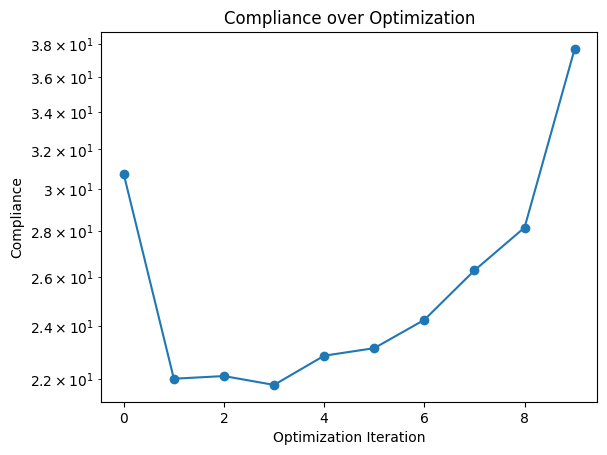

In [309]:
plt.plot(loss_hist, marker="o")
plt.yscale("log")
plt.xlabel("Optimization Iteration")
plt.ylabel("Compliance")
plt.title("Compliance over Optimization")

In [310]:
for i in range(n_steps):
    mesh = aux_hist[i]["hex_mesh"]
    rho_dot = grad_storage[i + 3000][1][: len(mesh["faces"])][:, 0]
    pv_mesh = hex_to_pyvista(
        mesh["points"], mesh["faces"], {"rho": mesh["rho"], "rho_dot": rho_dot}
    )
    pv_mesh.save(f"vtks/fem_shapeopt_mesh{i + 1}.vtk")

In [311]:
from matplotlib import animation

# repeat the last frame a few times to show the final result
params_hist = params_hist + [params] * 20

fig = plt.figure(figsize=(7, 4))

design_inputs["precompute_jacobian"] = False

ims = []
for aux in aux_hist:
    sdf = aux["sdf"]

    im = plt.imshow((sdf[:, :, :] > 0).sum(axis=1).T, origin="lower", cmap="viridis")
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=10, blit=False, repeat_delay=2)
plt.close(fig)

ani.save("rho_bars_optim.gif", writer="pillow", fps=10)

In [303]:
# lets visualize the 3d meshes over the optimization
for i, aux in enumerate(aux_hist):
    plot_mesh(aux["surface_mesh"], save_path=f"tmp_img/mesh_optim_{i:03d}.png")